In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Clean sales data

In [2]:
def clean_and_concat_raw_sales_data(sales_paths): # Clean raw sales data then concatenate them

    # Create empty list to hold dfs
    dfs = []

    # Iterate through each file path
    for path in sales_paths:

        # Read and filter to get only data from branch 1100 and channel Retail Store
        df = pd.read_csv(path)
        df = df[(df['CHI NHÁNH'] == 1100) & (df['KÊNH'] == 'CHTT')]

        # Select and rename columns
        df = df[['SITE', 'MÃ KHÁCH', 'MÃ HÀNG', 'SLTT', 'NĂM', 'THÁNG', 'TUẦN']].rename(columns={
            'SITE': 'store_code',
            'MÃ KHÁCH': 'customer_code',
            'MÃ HÀNG': 'product_code',
            'SLTT': 'quantity',
            'NĂM': 'year',
            'THÁNG': 'month',
            'TUẦN': 'week'
        })

        # Standardize data types
        df['month'] = df['month'].astype(str).str[-2:]
        df['week'] = df['week'].astype(str).str[-2:]

        df = df.astype({
            'year': 'int32',
            'month': 'int32',
            'week': 'int32',
            'store_code': 'str',
            'customer_code': 'str',
            'product_code': 'str',
            'quantity': 'int32'
        })

        # Append to list dfs = [df1, df2, ...]
        dfs.append(df)

    # Concat cleaned dfs
    concat_df = pd.concat(dfs, ignore_index=True).sort_values(by=['year', 'month', 'week', 'store_code'])

    return concat_df

def group_concat_sales_data_by_year_week_storecode_productcode(concat_df): # Group the concatenated sales data by year, week, store code, and product code

    # Group cleaned and concatenated sales data by year, week, store code, and product code
    grouped_df = concat_df.groupby(['year', 'week', 'store_code', 'product_code']).agg({'quantity': 'sum'}).reset_index()

    return grouped_df

def create_full_combinations_of_year_week_storecode_productcode(grouped_df): # Create full combinations of year, week, store code, and product code with sales data

    # Take unique values of year, week, store code, and product code
    unique_year = grouped_df['year'].unique()
    unique_week = grouped_df['week'].unique()
    unique_store_code = grouped_df['store_code'].unique()
    unique_product_code = grouped_df['product_code'].unique()

    # Create full combinations of all unique values
    full_combinations_df = pd.MultiIndex.from_product([unique_year, unique_week, unique_store_code, unique_product_code], 
                                                  names=['year', 'week', 'store_code', 'product_code']).to_frame(index=False)
    return full_combinations_df

def join_grouped_df_with_combination_df(grouped_df, full_combinations_df): # Join the grouped df with the full combinations df

    # Join grouped df with fulls combination df
    sales_df = pd.merge(full_combinations_df, grouped_df, on=['year', 'week', 'store_code', 'product_code'], how='left')
    sales_df = sales_df.astype({
    'year': 'int32',
    'week': 'int32',
    'store_code': 'int32',
    'product_code': 'str'
    })

    return sales_df

def full_process_sales_data(*sales_paths: str) -> pd.DataFrame: # Process all functions

    # Clean and concatenate raw sales files
    concat_df = clean_and_concat_raw_sales_data(sales_paths)

    # Group by year, week, store code, and product code
    grouped_df = group_concat_sales_data_by_year_week_storecode_productcode(concat_df)

    # Create combination of year, week, store code, and product code
    combination_df = create_full_combinations_of_year_week_storecode_productcode(grouped_df)

    # Join grouped data with combination data
    sales_df = join_grouped_df_with_combination_df(grouped_df, combination_df)

    return sales_df

# 2. Clean inventory data

In [3]:
def melt_and_concat_inventory_data(*inv_paths: str) -> pd.DataFrame: # Melt and concatenate raw inventory data

    # Create empty list to hold dfs
    dfs = []

    # Iterate through each file path
    for inv_path in inv_paths:

        # Read and melt inventory data
        df = pd.read_csv(inv_path)
        df = pd.melt(df, id_vars=['store_code', 'product_code'], var_name='year_week', value_name='inventory_quantity')

        # Create year and week columns
        df['year'] = df['year_week'].str[:4]
        df['week'] = df['year_week'].str[4:]
        
        df = df.astype({
        'year': 'int32',
        'week': 'int32',
        'store_code': 'int32',
        'product_code': 'str'
        })

        # Remove column 'year_week'
        df = df.drop(columns=['year_week'])

        # Append to list
        dfs.append(df)

    # Concat cleaned dfs
    inv_df = pd.concat(dfs, ignore_index=True)
    inv_df = inv_df.sort_values(by=['year', 'week', 'store_code'])
    
    # Concatenate all melted dfs
    return inv_df

# 3. Join sales and inventory data

In [4]:
def join_sales_and_inventory(sales_paths, inv_paths): # Join the processed sales and inventory data

    # Clean sales and inventory data
    sales_df = full_process_sales_data(*sales_paths)
    inv_df = melt_and_concat_inventory_data(*inv_paths)

    # Join sales and inventory data
    sales_inv_df = pd.merge(sales_df, inv_df, on=['year', 'week', 'store_code', 'product_code'], how='left')

    # Fill NA for quantity and inventory_quantity
    sales_inv_df['quantity'] = sales_inv_df['quantity'].fillna(0)
    sales_inv_df['inventory_quantity'] = sales_inv_df['inventory_quantity'].fillna(0)

    return sales_inv_df

# 4. Calculate corrected sales

In [5]:
def calculate_average_8w_in_stock(sales_in_stock_col):

    # Calculate the rolling average of sales in stock over the last 8 weeks, ignoring zero values
    return sales_in_stock_col.rolling(window=8, min_periods=1).apply(
        lambda x: x[x > 0].mean() if (x > 0).any() else 0,
        raw=True
    )

def calculate_average_4w_in_stock(sales_in_stock_col):

    # Calculate the rolling average of sales in stock over the last 4 weeks, ignoring zero values
    return sales_in_stock_col.rolling(window=4, min_periods=1).apply(
        lambda x: x[x > 0].mean() if (x > 0).any() else 0,
        raw=True
    )

def calculate_lost_sales_8w(df):

    # Create 'lost_sales' column
    df['lost_sales_8w'] = np.where(
        df['average_8w_sales_in_stock'] > df['quantity'],
        df['average_8w_sales_in_stock'] - df['quantity'],
        0
    )
    return df

def calculate_lost_sales_4w(df):

    # Create 'lost_sales' column
    df['lost_sales_4w'] = np.where(
        df['average_4w_sales_in_stock'] > df['quantity'],
        df['average_4w_sales_in_stock'] - df['quantity'],
        0
    )
    return df

def calculate_corrected_sales(df):

    # Create 'in_stock' column and 'sales_in_stock' column
    df['in_stock'] = (df['inventory_quantity'] > 0).astype(int)
    df['sales_in_stock'] = df['quantity'] * df['in_stock']

    # Sort the df
    df.sort_values(by=['product_code', 'store_code', 'year', 'week'], inplace=True)

    # Create 'average_4w_sales_in_stock' column by rolling average of sales in stock over the last 4 weeks, ignoring zero values
    df['average_4w_sales_in_stock'] = (
        df.groupby(['product_code', 'store_code'])['sales_in_stock']
          .transform(calculate_average_4w_in_stock)
    )

    # Create 'average_8w_sales_in_stock' column by rolling average of sales in stock over the last 8 weeks, ignoring zero values
    df['average_8w_sales_in_stock'] = (
        df.groupby(['product_code', 'store_code'])['sales_in_stock']
          .transform(calculate_average_8w_in_stock)
    )

    # Create 'lost_sales' columns
    df = calculate_lost_sales_8w(df)
    df = calculate_lost_sales_4w(df)

    # Create 'corrected_sales' columns
    df['corrected_sales_8w'] = df['quantity'] + df['lost_sales_8w']
    df['corrected_sales_4w'] = df['quantity'] + df['lost_sales_4w']

    return df

# 5. Run

In [6]:
# Sales paths
sales_path_1 = "D:\\retail_planning_project\\0. input_data\\sales\\raw_data\\sales_2023.csv"
sales_path_2 = "D:\\retail_planning_project\\0. input_data\\sales\\raw_data\\sales_2024.csv"
sales_paths = (sales_path_1, sales_path_2)

# Inventory paths
inv_path_1 = "D:\\retail_planning_project\\0. input_data\\inventory\\raw_data\\inventory_2023.csv"
inv_path_2 = "D:\\retail_planning_project\\0. input_data\\inventory\\raw_data\\inventory_2024.csv"
inv_paths = (inv_path_1, inv_path_2)

sales_inv_df = join_sales_and_inventory(sales_paths, inv_paths).sort_values(by=['product_code', 'store_code', 'year', 'week']).reset_index(drop=True)
corrected_sales_df = calculate_corrected_sales(sales_inv_df)

C:\Users\thanh\AppData\Local\Temp\ipykernel_18220\384947416.py:10: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
C:\Users\thanh\AppData\Local\Temp\ipykernel_18220\384947416.py:10: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [7]:
corrected_sales_df

,year,week,store_code,product_code,quantity,inventory_quantity,in_stock,sales_in_stock,average_4w_sales_in_stock,average_8w_sales_in_stock,lost_sales_8w,lost_sales_4w,corrected_sales_8w,corrected_sales_4w
0,2023,1,1101,AAUH00200DEN37,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023,2,1101,AAUH00200DEN37,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023,3,1101,AAUH00200DEN37,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,4,1101,AAUH00200DEN37,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023,5,1101,AAUH00200DEN37,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225021883,2024,48,1813,X09402000DEN41,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
225021884,2024,49,1813,X09402000DEN41,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
225021885,2024,50,1813,X09402000DEN41,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
225021886,2024,51,1813,X09402000DEN41,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df = corrected_sales_df.groupby(by=['year', 'week']).agg(quantity=('quantity', 'sum'), 
                                                         corrected_sales_4w=('corrected_sales_4w', 'sum'), 
                                                         corrected_sales_8w=('corrected_sales_8w', 'sum')).reset_index()
df

,year,week,quantity,corrected_sales_4w,corrected_sales_8w
0,2023,1,69989.0,70533.000000,70533.000000
1,2023,2,86357.0,111891.500000,111891.500000
2,2023,3,84782.0,140190.500000,140190.500000
3,2023,4,13490.0,120901.833333,120901.833333
4,2023,5,26544.0,106423.333333,130097.883333
...,...,...,...,...,...
99,2024,48,32632.0,69045.750000,103037.052381
100,2024,49,30684.0,70588.083333,104632.294048
101,2024,50,30650.0,71891.250000,105860.486905
102,2024,51,37051.0,77385.750000,112058.022619


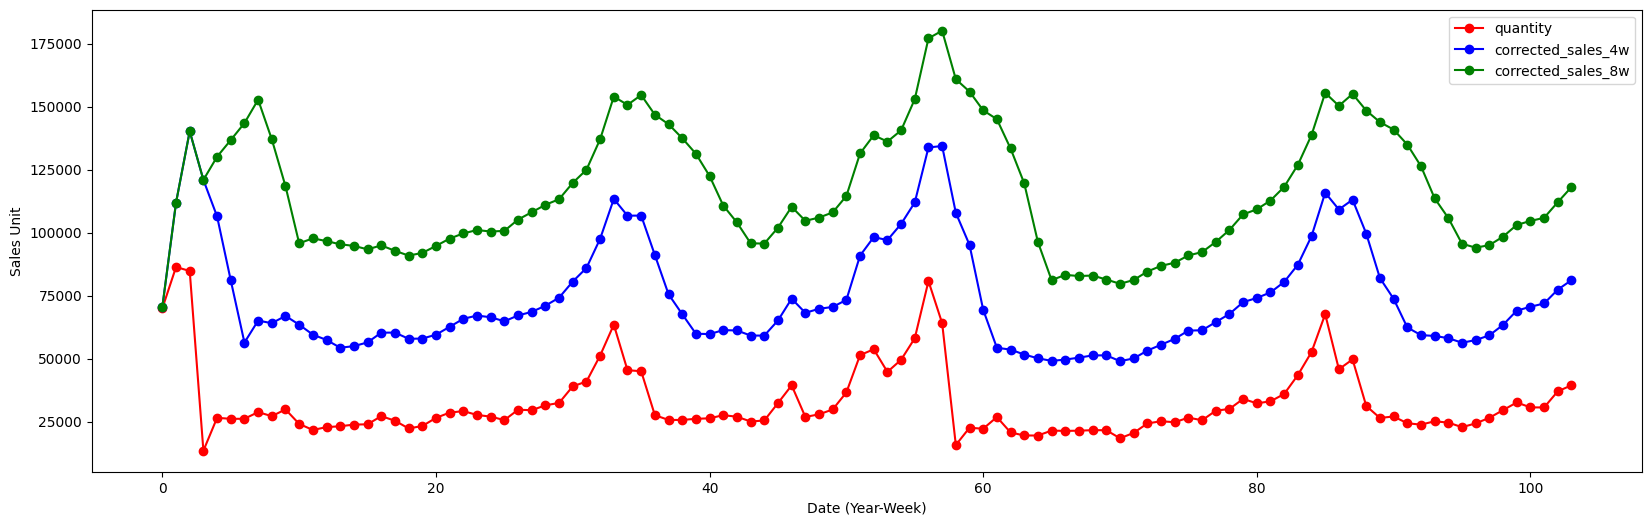

In [9]:
# Visualize the actual sales and corrected sales

df.set_index(['year', 'week'])

plt.figure(figsize=(20, 6))

plt.plot(df.index, df['quantity'], marker='o', color = 'red', label='quantity')
plt.plot(df.index, df['corrected_sales_4w'], marker='o', color = 'blue', label='corrected_sales_4w')
plt.plot(df.index, df['corrected_sales_8w'], marker='o', color = 'green', label = 'corrected_sales_8w')

plt.xlabel("Date (Year-Week)")
plt.ylabel("Sales Unit")
plt.legend()
plt.show()